In [1]:
import os
import fitsio
import desimodel
import astropy
import pandas                as     pd
import pylab                 as     pl
import numpy                 as     np
import astropy.io.fits       as     fits
import matplotlib.pyplot     as     plt

from   datetime              import datetime
from   astropy.table         import Table, vstack, join
from   astropy.coordinates   import Angle, SkyCoord
from   astropy               import units as u

from   desimodel.footprint   import is_point_in_desi
from   desimodel             import io
from   desitarget.geomask    import circles
from   desitarget.targetmask import desi_mask, obsconditions

In [2]:
def laigle():
  f      = open('/global/homes/m/mjwilson/DESILBG/target/proposals/laigle/cosmos_zphot_mag25.tbl', 'r')

  line   = f.readline()

  names  = [x for x in line.split() if x != '|'] 

  names  = [x.replace('|', '') for x in names][1:]

  laigle = pd.read_csv('/global/homes/m/mjwilson/DESILBG/target/proposals/laigle/cosmos_zphot_mag25.tbl', comment='#', sep='\s+', names=names)

  # laigle = laigle[np.isfinite(laigle['zp_best'])]

  # isin = (laigle['zp_best'] > 1.8) & (laigle['zp_best'] < 5.0) & (laigle['imag'] < 24.0)

  return laigle # [isin]

In [3]:
def get_kids(field='G9'):
    # fields = ['G9', 'G12', 'G15']
    # NOTE: u band limit of 24.8
    kids = Table() 
    
    kids = vstack((kids, Table.read('/global/homes/m/mjwilson/DESILBG/target/proposals/kids/KiDS_DR3.1_{}_ugri_shear.fits'.format(field))))                  
    
    kids = fitsio.read('/global/homes/m/mjwilson/DESILBG/target/proposals/kids/KiDS_DR3.1_{}_ugri_shear.fits'.format(field))
    
    return  Table(kids)

In [4]:
def get_hildebrandt(field='D1'):
    # SXDS:  (02:18:00.00, −05:00:00.00), D1 encompassed by W1.  
    dat  = Table.read('/global/cscratch1/sd/mjwilson/DESILBG/Hildebrandt/{}.cat'.format(field))
    
    return  dat

In [5]:
def get_cfhtls_wide():
    # https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/megapipe/cfhtls/uc.html; I-band detected. 
    # u-band limit of 25.2 in the wide field.
    filename = '/global/cscratch1/sd/mjwilson/CFHTLS/W.I.con.cat'     
    
    names    = []

    with open(filename, 'r') as fh:
      for curline in fh:
         if curline.startswith("#"):
              words = curline.split()
              names.append(words[2])

         else:
            break
    
    fh.close()
    
    dat   = pd.read_csv(filename, sep='\s+', comment='#', names=names)
                        
    return  dat

In [6]:
def get_goldrush():
    # https://arxiv.org/pdf/1704.06004.pdf
    dat   = Table.read('/global/homes/m/mjwilson/DESILBG/target/proposals/goldrush/goldrush_mizukizs.fits')    
    
    return dat

In [7]:
def get_laes():
    # https://arxiv.org/pdf/0801.4017.pdf
    dat   = pd.read_csv('/global/homes/m/mjwilson/DESILBG/target/proposals/sxds_laes.txt', sep='\s+', comment='#')
    
    dat.drop(dat.columns[list(np.arange(7, 20, 1))], axis=1, inplace=True)
    
    dat.columns = ['Row', 'Name', 'RA', 'DEC', 'None', 'Velocity', 'Redshift']
    dat['RA']   = [Angle(x).deg for x in dat['RA']]
    dat['DEC']  = [Angle(x[:-1] + '.0s').deg for x in dat['DEC']]
    
    return  dat

In [8]:
def get_vvds():
    # https://cesam.lam.fr/vvds/vvds_download.php
    dat = pd.read_csv('/global/cscratch1/sd/mjwilson/VVDS/cesam_vvds_spF02_DEEP_Full.txt', sep='\s+')

    # Cut.
    dat = dat[dat['Z'] < 9.0]
    
    return dat

In [9]:
def get_splash():
    dat = Table.read('/global/cscratch1/sd/mjwilson/SPLASH/SPLASH_SXDF_Mehta+_v1.6.fits')
    
    return dat

In [10]:
# hiz  = laigle()

In [11]:
# kids = get_kids()

In [12]:
splash = get_splash()

In [13]:
splash_zspec = splash[splash['ZSPEC'] > 0.]

In [16]:
hilde  = get_hildebrandt()

In [17]:
grush  = get_goldrush()

In [18]:
laes   = get_laes()

In [19]:
cfhtls = get_cfhtls_wide()

In [20]:
vvds   = get_vvds()

In [21]:
splash

ID,RA,DEC,A,B,THETA,X_IMAGE,Y_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,KRON_RADIUS,PETRO_RADIUS,ISOAREAF_IMAGE,ELONGATION,ELLIPTICITY,GAL_EXT_EBV,OFFSET_FLUX [5],OFFSET_MAG [5],ZSPEC,ZSPEC_REF,ZPHOT,STAR_FLAG,MAG_AUTO_hsc_g,MAGERR_AUTO_hsc_g,FLUX_AUTO_hsc_g,FLUXERR_AUTO_hsc_g,MAG_ISO_hsc_g,MAGERR_ISO_hsc_g,FLUX_ISO_hsc_g,FLUXERR_ISO_hsc_g,MAG_APER_hsc_g [5],MAGERR_APER_hsc_g [5],FLUX_APER_hsc_g [5],FLUXERR_APER_hsc_g [5],FLUX_RADIUS_hsc_g [3],SE_FLAGS_hsc_g,COVERAGE_FLAG_hsc_g,MAG_AUTO_hsc_r,MAGERR_AUTO_hsc_r,FLUX_AUTO_hsc_r,FLUXERR_AUTO_hsc_r,MAG_ISO_hsc_r,MAGERR_ISO_hsc_r,FLUX_ISO_hsc_r,FLUXERR_ISO_hsc_r,MAG_APER_hsc_r [5],MAGERR_APER_hsc_r [5],FLUX_APER_hsc_r [5],FLUXERR_APER_hsc_r [5],FLUX_RADIUS_hsc_r [3],SE_FLAGS_hsc_r,COVERAGE_FLAG_hsc_r,MAG_AUTO_hsc_i,MAGERR_AUTO_hsc_i,FLUX_AUTO_hsc_i,FLUXERR_AUTO_hsc_i,MAG_ISO_hsc_i,MAGERR_ISO_hsc_i,FLUX_ISO_hsc_i,FLUXERR_ISO_hsc_i,MAG_APER_hsc_i [5],MAGERR_APER_hsc_i [5],FLUX_APER_hsc_i [5],FLUXERR_APER_hsc_i [5],FLUX_RADIUS_hsc_i [3],SE_FLAGS_hsc_i,COVERAGE_FLAG_hsc_i,MAG_AUTO_hsc_z,MAGERR_AUTO_hsc_z,FLUX_AUTO_hsc_z,FLUXERR_AUTO_hsc_z,MAG_ISO_hsc_z,MAGERR_ISO_hsc_z,FLUX_ISO_hsc_z,FLUXERR_ISO_hsc_z,MAG_APER_hsc_z [5],MAGERR_APER_hsc_z [5],FLUX_APER_hsc_z [5],FLUXERR_APER_hsc_z [5],FLUX_RADIUS_hsc_z [3],SE_FLAGS_hsc_z,COVERAGE_FLAG_hsc_z,MAG_AUTO_hsc_y,MAGERR_AUTO_hsc_y,FLUX_AUTO_hsc_y,FLUXERR_AUTO_hsc_y,MAG_ISO_hsc_y,MAGERR_ISO_hsc_y,FLUX_ISO_hsc_y,FLUXERR_ISO_hsc_y,MAG_APER_hsc_y [5],MAGERR_APER_hsc_y [5],FLUX_APER_hsc_y [5],FLUXERR_APER_hsc_y [5],FLUX_RADIUS_hsc_y [3],SE_FLAGS_hsc_y,COVERAGE_FLAG_hsc_y,MAG_AUTO_supcam_b,MAGERR_AUTO_supcam_b,FLUX_AUTO_supcam_b,FLUXERR_AUTO_supcam_b,MAG_ISO_supcam_b,MAGERR_ISO_supcam_b,FLUX_ISO_supcam_b,FLUXERR_ISO_supcam_b,MAG_APER_supcam_b [5],MAGERR_APER_supcam_b [5],FLUX_APER_supcam_b [5],FLUXERR_APER_supcam_b [5],FLUX_RADIUS_supcam_b [3],SE_FLAGS_supcam_b,COVERAGE_FLAG_supcam_b,MAG_AUTO_supcam_v,MAGERR_AUTO_supcam_v,FLUX_AUTO_supcam_v,FLUXERR_AUTO_supcam_v,MAG_ISO_supcam_v,MAGERR_ISO_supcam_v,FLUX_ISO_supcam_v,FLUXERR_ISO_supcam_v,MAG_APER_supcam_v [5],MAGERR_APER_supcam_v [5],FLUX_APER_supcam_v [5],FLUXERR_APER_supcam_v [5],FLUX_RADIUS_supcam_v [3],SE_FLAGS_supcam_v,COVERAGE_FLAG_supcam_v,MAG_AUTO_supcam_r,MAGERR_AUTO_supcam_r,FLUX_AUTO_supcam_r,FLUXERR_AUTO_supcam_r,MAG_ISO_supcam_r,MAGERR_ISO_supcam_r,FLUX_ISO_supcam_r,FLUXERR_ISO_supcam_r,MAG_APER_supcam_r [5],MAGERR_APER_supcam_r [5],FLUX_APER_supcam_r [5],FLUXERR_APER_supcam_r [5],FLUX_RADIUS_supcam_r [3],SE_FLAGS_supcam_r,COVERAGE_FLAG_supcam_r,MAG_AUTO_supcam_i,MAGERR_AUTO_supcam_i,FLUX_AUTO_supcam_i,FLUXERR_AUTO_supcam_i,MAG_ISO_supcam_i,MAGERR_ISO_supcam_i,FLUX_ISO_supcam_i,FLUXERR_ISO_supcam_i,MAG_APER_supcam_i [5],MAGERR_APER_supcam_i [5],FLUX_APER_supcam_i [5],FLUXERR_APER_supcam_i [5],FLUX_RADIUS_supcam_i [3],SE_FLAGS_supcam_i,COVERAGE_FLAG_supcam_i,MAG_AUTO_supcam_z,MAGERR_AUTO_supcam_z,FLUX_AUTO_supcam_z,FLUXERR_AUTO_supcam_z,MAG_ISO_supcam_z,MAGERR_ISO_supcam_z,FLUX_ISO_supcam_z,FLUXERR_ISO_supcam_z,MAG_APER_supcam_z [5],MAGERR_APER_supcam_z [5],FLUX_APER_supcam_z [5],FLUXERR_APER_supcam_z [5],FLUX_RADIUS_supcam_z [3],SE_FLAGS_supcam_z,COVERAGE_FLAG_supcam_z,MAG_AUTO_uds_j,MAGERR_AUTO_uds_j,FLUX_AUTO_uds_j,FLUXERR_AUTO_uds_j,MAG_ISO_uds_j,MAGERR_ISO_uds_j,FLUX_ISO_uds_j,FLUXERR_ISO_uds_j,MAG_APER_uds_j [5],MAGERR_APER_uds_j [5],FLUX_APER_uds_j [5],FLUXERR_APER_uds_j [5],FLUX_RADIUS_uds_j [3],SE_FLAGS_uds_j,COVERAGE_FLAG_uds_j,MAG_AUTO_uds_h,MAGERR_AUTO_uds_h,FLUX_AUTO_uds_h,FLUXERR_AUTO_uds_h,MAG_ISO_uds_h,MAGERR_ISO_uds_h,FLUX_ISO_uds_h,FLUXERR_ISO_uds_h,MAG_APER_uds_h [5],MAGERR_APER_uds_h [5],FLUX_APER_uds_h [5],FLUXERR_APER_uds_h [5],FLUX_RADIUS_uds_h [3],SE_FLAGS_uds_h,COVERAGE_FLAG_uds_h,MAG_AUTO_uds_k,MAGERR_AUTO_uds_k,FLUX_AUTO_uds_k,FLUXERR_AUTO_uds_k,MAG_ISO_uds_k,MAGERR_ISO_uds_k,FLUX_ISO_uds_k,FLUXERR_ISO_uds_k,MAG_APER_uds_k [5],MAGERR_APER_uds_k [5],FLUX_APER_uds_k [5],FLUXERR_APER_uds_k [5],FLUX_RADIUS_uds_k [3],SE_FLAGS_uds_k,COVERAGE_FLAG_uds_k,MAG_AUTO_video_z,MAGERR_

In [23]:
hilde

FIELD_POS,SeqNr,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_ISOCOR,FLUXERR_ISOCOR,MAG_ISOCOR,MAGERR_ISOCOR,FLUX_APER [24],FLUXERR_APER [24],MAG_APER [24],MAGERR_APER [24],FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,FLUX_BEST,FLUXERR_BEST,MAG_BEST,MAGERR_BEST,KRON_RADIUS,BackGr,Level,MU_THRESHOLD,MaxVal,MU_MAX,NPIX,ISOAREA_WORLD,XMIN_IMAGE,YMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,Xpos,Ypos,X_WORLD,Y_WORLD,ALPHA_SKY,DELTA_SKY,ALPHA_J2000,DELTA_J2000,ALPHA_B1950,DELTA_B1950,XM2,YM2,Corr,X2_WORLD,Y2_WORLD,XY_WORLD,CXX_IMAGE,CYY_IMAGE,CXY_IMAGE,CXX_WORLD,CYY_WORLD,CXY_WORLD,A,B,A_WORLD,B_WORLD,Theta,THETA_WORLD,THETA_SKY,THETA_J2000,THETA_B1950,ELONGATION,ELLIPTICITY,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,ERRX2_WORLD,ERRY2_WORLD,ERRXY_WORLD,ERRCXX_IMAGE,ERRCYY_IMAGE,ERRCXY_IMAGE,ERRCXX_WORLD,ERRCYY_WORLD,ERRCXY_WORLD,ERRA_IMAGE,ERRB_IMAGE,ERRA_WORLD,ERRB_WORLD,ERRTHETA_IMAGE,ERRTHETA_WORLD,ERRTHETA_SKY,ERRTHETA_J2000,ERRTHETA_B1950,FWHM_IMAGE,FWHM_WORLD,ISO0,ISO1,ISO2,ISO3,ISO4,ISO5,ISO6,ISO7,Flag,FLUX_RADIUS,IMAFLAGS_ISO,NIMAFLAGS_ISO,CLASS_STAR,"VIGNET [5,5]",MAG_ISO_u,MAG_ISOCOR_u,MAG_AUTO_u,MAG_APER_u [24],MAGERR_ISO_u,MAGERR_ISOCOR_u,MAGERR_AUTO_u,MAGERR_APER_u [24],MAG_LIM_u,FLUX_ISO_u,FLUX_ISOCOR_u,FLUX_AUTO_u,FLUX_APER_u [24],FLUXERR_ISO_u,FLUXERR_ISOCOR_u,FLUXERR_AUTO_u,FLUXERR_APER_u [24],MAG_ISO_g,MAG_ISOCOR_g,MAG_AUTO_g,MAG_APER_g [24],MAGERR_ISO_g,MAGERR_ISOCOR_g,MAGERR_AUTO_g,MAGERR_APER_g [24],MAG_LIM_g,FLUX_ISO_g,FLUX_ISOCOR_g,FLUX_AUTO_g,FLUX_APER_g [24],FLUXERR_ISO_g,FLUXERR_ISOCOR_g,FLUXERR_AUTO_g,FLUXERR_APER_g [24],MAG_ISO_r,MAG_ISOCOR_r,MAG_AUTO_r,MAG_APER_r [24],MAGERR_ISO_r,MAGERR_ISOCOR_r,MAGERR_AUTO_r,MAGERR_APER_r [24],MAG_LIM_r,FLUX_ISO_r,FLUX_ISOCOR_r,FLUX_AUTO_r,FLUX_APER_r [24],FLUXERR_ISO_r,FLUXERR_ISOCOR_r,FLUXERR_AUTO_r,FLUXERR_APER_r [24],MAG_ISO_i,MAG_ISOCOR_i,MAG_AUTO_i,MAG_APER_i [24],MAGERR_ISO_i,MAGERR_ISOCOR_i,MAGERR_AUTO_i,MAGERR_APER_i [24],MAG_LIM_i,FLUX_ISO_i,FLUX_ISOCOR_i,FLUX_AUTO_i,FLUX_APER_i [24],FLUXERR_ISO_i,FLUXERR_ISOCOR_i,FLUXERR_AUTO_i,FLUXERR_APER_i [24],MAG_ISO_z,MAG_ISOCOR_z,MAG_AUTO_z,MAG_APER_z [24],MAGERR_ISO_z,MAGERR_ISOCOR_z,MAGERR_AUTO_z,MAGERR_APER_z [24],MAG_LIM_z,FLUX_ISO_z,FLUX_ISOCOR_z,FLUX_AUTO_z,FLUX_APER_z [24],FLUXERR_ISO_z,FLUXERR_ISOCOR_z,FLUXERR_AUTO_z,FLUXERR_APER_z [24],MASK_u,MASK_g,MASK_r,MASK_i,MASK_z,MASK_STARS,u_g_ISO,g_r_ISO,r_i_ISO,i_z_ISO,u_r_ISO,g_i_ISO,r_z_ISO,u_i_ISO,g_z_ISO,u_z_ISO,Z_PHOT,CHI_SQUARE,PROB_CHI,SpT,Nage,Age,Av,b,Zinf99,Zsup99,Zinf90,Zsup90,Zinf68,Zsup68,Zwm,PROB_CHIwm,MAGABS_i,P_int,Ly_forest,Z_PHOT2,PROB_CHI2,b_scale,maskgsct,maskgscw,maskgscw2,maskast1,maskast2,maskast3,maskast4,masksa,Z_PHOT_BC,CHI_SQUARE_BC,PROB_CHI_BC,SpT_BC,Nage_BC,Age_BC,Av_BC,b_BC,Zinf99_BC,Zsup99_BC,Zinf90_BC,Zsup90_BC,Zinf68_BC,Zsup68_BC,Zwm_BC,PROB_CHIwm_BC,MAGABS_i_BC,Ly_forest_BC,Z_PHOT2_BC,PROB_CHI2_BC,EXT_u,EXT_g,EXT_r,EXT_i,EXT_z,u_g_ISO_cor,u_r_ISO_cor,u_i_ISO_cor,u_z_ISO_cor,g_r_ISO_cor,g_i_ISO_cor,g_z_ISO_cor,r_i_ISO_cor,r_z_ISO_cor,i_z_ISO_cor,Z_B_V3,Z_B_MIN_V3,Z_B_MAX_V3,T_B_V3,ODDS_V3,Z_ML_V3,T_ML_V3,CHI_SQUARED_BPZ_V3,M_0_V3,u_g_ISO_cor2,u_r_ISO_cor2,u_i_ISO_cor2,u_z_ISO_cor2,g_r_ISO_cor2,g_i_ISO_cor2,g_z_ISO_cor2,r_i_ISO_cor2,r_z_ISO_cor2,i_z_ISO_cor2
,,ct,ct,mag,mag,ct,ct,mag,mag,ct,ct,mag,mag,ct,ct,mag,mag,ct,ct,mag,mag,,ct,ct,mag / arcsec2,ct,mag / arcsec2,pix2,deg2,pix,pix,pix,pix,pix,pix,deg,deg,deg,deg,deg,deg,deg,deg,pix2,pix2,pix2,deg2,deg2,deg2,1 / pix2,1 / pix2,1 / pix2,1 / deg2,1 / deg2,1 / deg2,pix,pix,deg,deg,deg,deg,deg,deg,deg,,,pix2,pix2,pix2,deg2,deg2,deg2,1 / pix2,1 / pix2,1 / pix2,1 / deg2,1 / deg2,1 / deg2,pixelstat.stdev;stat.max;pos.errorEllipse;instr.det;meta.main,pix,pix,pix,deg,deg,deg,deg,deg,pix,deg,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,,pix,,,,ct,mag,mag,mag,mag,mag,mag,mag,mag,"""""",ct,ct,ct,ct,ct,ct,ct,ct,mag,mag,mag,mag,mag,mag,mag,mag,"""""",ct,ct,ct,ct,ct,ct,ct,ct,mag,mag,mag,mag,mag,mag,mag,mag,"""""",ct,ct,ct,ct,ct,ct,ct,ct,mag,mag,mag,mag,mag,mag,mag,mag,"""""",ct,ct,ct,ct,ct,ct,ct,ct,mag,mag,mag,mag,mag,mag,m

Text(0.5, 1.0, 'Splash & Hildebrandt dropouts')

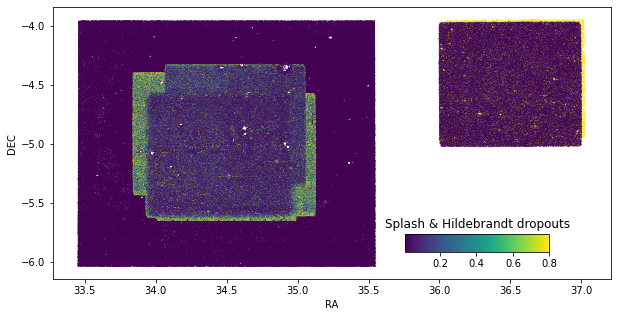

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 

im      = pl.scatter(splash['RA'], splash['DEC'], c=splash['MAGERR_AUTO_musubi_u'], marker='.', s=2, lw=0.0, vmin=0.01, vmax=0.8)
im      = pl.scatter(hilde['ALPHA_J2000'], hilde['DELTA_J2000'], c=hilde['MAGERR_ISOCOR_u'], marker='.', s=2, lw=0.0, vmin=0.01, vmax=0.8)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

cax = fig.add_axes([0.615, 0.2, 0.2, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

pl.title('Splash & Hildebrandt dropouts')

In [84]:
splash['u-g'] = splash['MAG_AUTO_musubi_u'] - splash['MAG_AUTO_hsc_g']
splash['g-r'] = splash['MAG_AUTO_hsc_g']    - splash['MAG_AUTO_hsc_r']
splash['r-i'] = splash['MAG_AUTO_hsc_r']    - splash['MAG_AUTO_hsc_i']

In [18]:
# hilde.dtype.names

In [146]:
isin = (cfhtls['RA'] > 33.25) & (cfhtls['RA'] < 39.0) & (cfhtls['DEC'] > -7.00) & (cfhtls['DEC'] < -2.5)

In [147]:
# Percent of CFHTLS-Wide in D1.
100. * np.count_nonzero(isin) / len(cfhtls)

11.44624806073507

In [148]:
cfhtls_D1 = cfhtls[isin]

In [149]:
cfhtls_D1 = Table(cfhtls_D1.to_numpy(), names=cfhtls_D1.columns)

Text(0.5, 1.0, 'CFHTLS Wide-selected footprint')

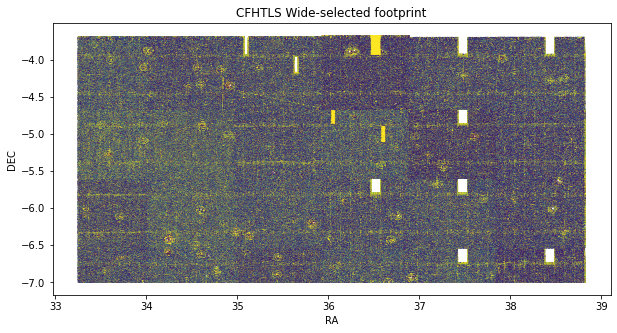

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 

ax.scatter(cfhtls_D1['RA'], cfhtls_D1['DEC'], c=cfhtls_D1['U_MAGERR_AUTO'], marker='.', s=2, lw=0.0, vmin=0.05, vmax=1.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

pl.title('CFHTLS Wide-selected footprint')

In [39]:
# cfhtls_D1.dtype.names

In [40]:
cfhtls_D1['u-g'] = cfhtls_D1['U_MAG_AUTO'] - cfhtls_D1['G_MAG_AUTO']
cfhtls_D1['g-r'] = cfhtls_D1['G_MAG_AUTO'] - cfhtls_D1['R_MAG_AUTO']
cfhtls_D1['r-i'] = cfhtls_D1['R_MAG_AUTO'] - cfhtls_D1['I_MAG_AUTO']

In [143]:
isin     = (grush['ra'] > 33.25) & (grush['ra'] < 39.0) & (grush['dec'] > -7.00) & (grush['dec'] < -2.5)

In [144]:
grush_D1 = grush[isin]

Text(0.5, 1.0, 'Goldrush footprint')

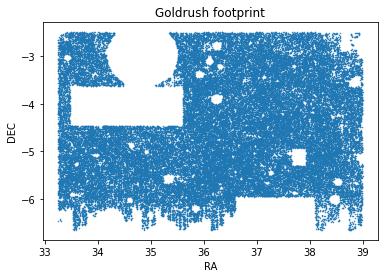

In [145]:
pl.plot(grush_D1['ra'], grush_D1['dec'], marker='.', markersize=1, lw=0.0)

pl.xlabel('RA')
pl.ylabel('DEC')

pl.title('Goldrush footprint')

In [44]:
# grush_D1.dtype.names

In [45]:
grush_D1['g-r'] = grush_D1['gcmodel_mag'] - grush_D1['rcmodel_mag']
grush_D1['r-i'] = grush_D1['rcmodel_mag'] - grush_D1['icmodel_mag']

Text(0.5, 1.0, 'Goldrush $g$-dropouts')

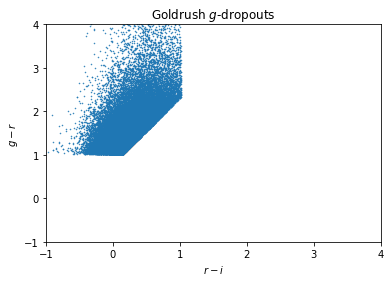

In [46]:
pl.plot(grush_D1['r-i'], grush_D1['g-r'], marker='.', lw=0.0, markersize=1.)

pl.xlabel('$r-i$')
pl.ylabel('$g-r$')

pl.xlim(-1., 4.)
pl.ylim(-1., 4.)

pl.title('Goldrush $g$-dropouts')

Text(0.5, 1.0, 'Goldrush $g$-dropouts magnitude distribution')

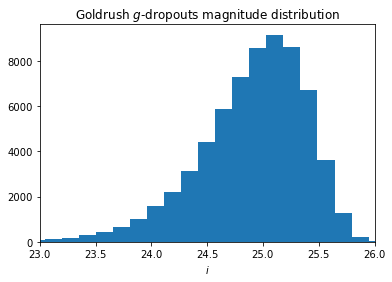

In [47]:
pl.hist(grush_D1['icmodel_mag'], bins=50)

pl.xlim(23., 26.)
pl.xlabel('$i$')

pl.title('Goldrush $g$-dropouts magnitude distribution')

Text(0.5, 1.0, 'Ouchi SXDS LAEs')

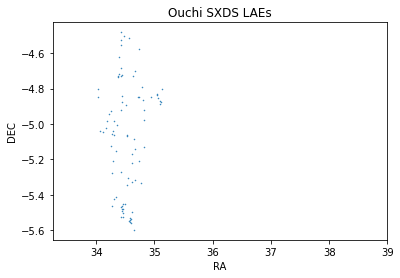

In [48]:
pl.plot(laes['RA'], laes['DEC'], marker='.', markersize=1, lw=0.0)

pl.xlabel('RA')
pl.ylabel('DEC')

pl.xlim(33.25, 39.0)
pl.title('Ouchi SXDS LAEs')

Text(0.5, 1.0, 'VVDS footprint')

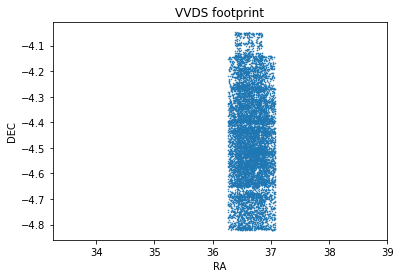

In [49]:
pl.plot(vvds['ALPHA'], vvds['DELTA'], marker='.', markersize=1, lw=0.0)

pl.xlabel('RA')
pl.ylabel('DEC')

pl.xlim(33.25, 39.0)
pl.title('VVDS footprint')

Text(0.5, 1.0, 'High redshift VVDS distribution')

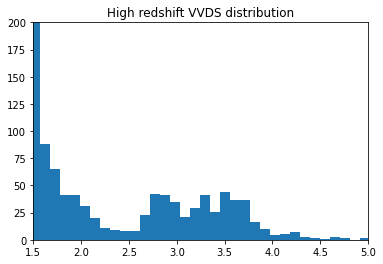

In [50]:
_ = pl.hist(vvds['Z'], bins=50)

pl.xlim(1.5, 5.0)
pl.ylim(0., 200.)

pl.title('High redshift VVDS distribution')

In [51]:
np.count_nonzero(vvds['Z'] > 1.8)

597

In [52]:
c             = SkyCoord(ra=cfhtls_D1['RA'] * u.degree, dec= cfhtls_D1['DEC']* u.degree)
catalog       = SkyCoord(ra=hilde['ALPHA_J2000'], dec=hilde['DELTA_J2000'])

idxc, idxcatalog, d2d, d3d = catalog.search_around_sky(c, (0.25 / 60. / 60.) * u.deg)

d2d           = [x.deg * 60. * 60. for x in d2d]

In [54]:
indx, cnts    = np.unique(idxcatalog, return_counts=True)

# Degenerate matches.
np.count_nonzero(cnts > 1)

Text(0.5, 1.0, 'Hilde dropouts matched to CFHTLS Wide')

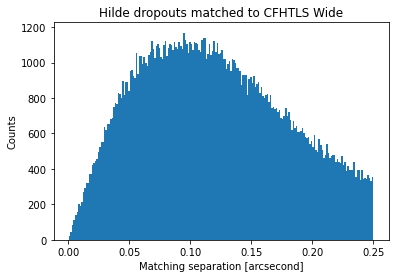

In [57]:
_             = pl.hist(d2d, bins=200)

pl.xlabel('Matching separation [arcsecond]')
pl.ylabel('Counts')

pl.title('Hilde dropouts matched to CFHTLS Wide')

In [58]:
hilde_wide        = cfhtls_D1[idxc]
hilde_match       = hilde[idxcatalog]

In [59]:
hilde_wide['u-g'] = hilde_wide['U_MAG_AUTO'] - hilde_wide['G_MAG_AUTO']
hilde_wide['g-r'] = hilde_wide['G_MAG_AUTO'] - hilde_wide['R_MAG_AUTO']
hilde_wide['r-i'] = hilde_wide['R_MAG_AUTO'] - hilde_wide['I_MAG_AUTO']

hilde_wide_sample = hilde_wide[::10]

In [60]:
# hilde_wide.dtype.names

(20.0, 28.0)

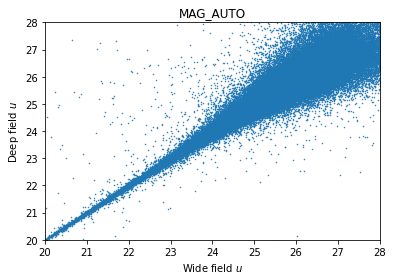

In [61]:
pl.scatter(hilde_wide['U_MAG_AUTO'], hilde_match['MAG_AUTO_u'], marker='.', s=1)

pl.xlabel('Wide field $u$')
pl.ylabel('Deep field $u$')

pl.title('MAG_AUTO')

pl.xlim(20., 28.)
pl.ylim(20., 28.)

(20.0, 28.0)

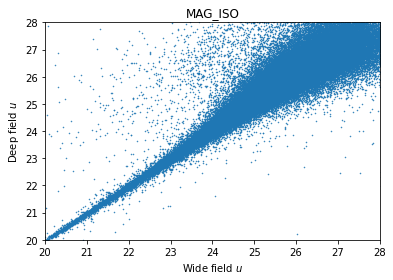

In [67]:
pl.scatter(hilde_wide['U_MAG_AUTO'], hilde_match['MAG_ISO_u'], marker='.', s=1)

pl.xlabel('Wide field $u$')
pl.ylabel('Deep field $u$')

pl.title('MAG_ISO')

pl.xlim(20., 28.)
pl.ylim(20., 28.)

In [68]:
c              = SkyCoord(ra=grush_D1['ra'] * u.degree, dec= grush_D1['dec']* u.degree)
catalog        = SkyCoord(ra=hilde['ALPHA_J2000'], dec=hilde['DELTA_J2000'])

idxc, idxcatalog, d2d, d3d = catalog.search_around_sky(c, (0.25 / 60. / 60.) * u.deg)

d2d            = [x.deg * 60. * 60. for x in d2d]

In [69]:
indx, cnts    = np.unique(idxcatalog, return_counts=True)

np.count_nonzero(cnts > 1)

0

Text(0.5, 1.0, 'Hilde dropouts matched to Goldrush')

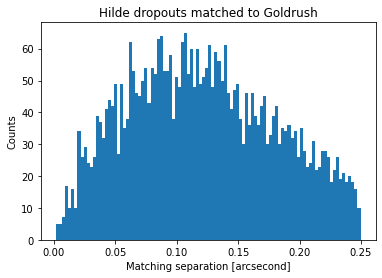

In [70]:
_              = pl.hist(d2d, bins=100)

pl.xlabel('Matching separation [arcsecond]')
pl.ylabel('Counts')

pl.title('Hilde dropouts matched to Goldrush')

In [71]:
hilde_grush       = grush_D1[idxc]
hilde_grush_match = hilde[idxcatalog]

In [72]:
def drops(dband='u'):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin  = hilde['CLASS_STAR'] <  0.9
    
    isin &= hilde['maskgscw']   ==   0
    isin &= hilde['masksa']     ==   0    
    
    isin &= hilde['MASK_STARS'] ==   0
    
    isin &= hilde['MASK_u']     ==   0
    isin &= hilde['MASK_g']     ==   0
    isin &= hilde['MASK_r']     ==   0
    isin &= hilde['MASK_i']     ==   0
    isin &= hilde['MASK_z']     ==   0
    
    if dband == 'BX':
        # LATIS, https://arxiv.org/pdf/2002.10676.pdf
        # 0.5 < u − g < 2.2 and −0.1 < g − r < 1.0 and u − g > 0.50 + 2.3(g − r − 0.35).
        isin &= hilde['u_g_ISO_cor2'] >  0.5
        isin &= hilde['u_g_ISO_cor2'] <  2.2
        isin &= hilde['g_r_ISO_cor2'] > -0.1
        isin &= hilde['g_r_ISO_cor2'] <  1.0
        isin &= hilde['u_g_ISO_cor2'] >  0.5 + 2.3 * (hilde['g_r_ISO_cor2'] - 0.35)
    
    elif dband == 'u':
      # u drops.
      # 1.5 < (u − g) and −1.0 < (g − r) < 1.2 and 1.5 · (g − r) < (u − g) − 0.75    
      isin &= hilde['u_g_ISO_cor2'] >  1.5
      isin &= hilde['g_r_ISO_cor2'] > -1.0
      isin &= hilde['g_r_ISO_cor2'] <  1.2
      isin &= 1.5 * hilde['g_r_ISO_cor2'] <  hilde['u_g_ISO_cor2'] - 0.75

    elif dband == 'g':
      # g drops
      # 1.0 < (g − r) and −1.0 < (r − i) < 1.0 and 1.5 · (r − i) < (g − r) − 0.8
      isin &= hilde['g_r_ISO_cor2'] >  1.0
      isin &= hilde['r_i_ISO_cor2'] > -1.0
      isin &= hilde['r_i_ISO_cor2'] <  1.0
      isin &= 1.5 * hilde['r_i_ISO_cor2'] < hilde['g_r_ISO_cor2'] - 0.80
    
    else:
        raise  ValueError('dband of {} is not supported; try [u, g].'.format(dband))
    
    return  isin        

In [73]:
xdrops = drops(dband='BX')
udrops = drops(dband='u')
gdrops = drops(dband='g')

adrops = xdrops | udrops | gdrops

xdrops = hilde[xdrops]
udrops = hilde[udrops]
gdrops = hilde[gdrops]

adrops = hilde[adrops]

In [75]:
# xdrops.dtype.names

Text(0.5, 0.98, 'Hildebrandt BX, $u$ & $g$ dropouts')

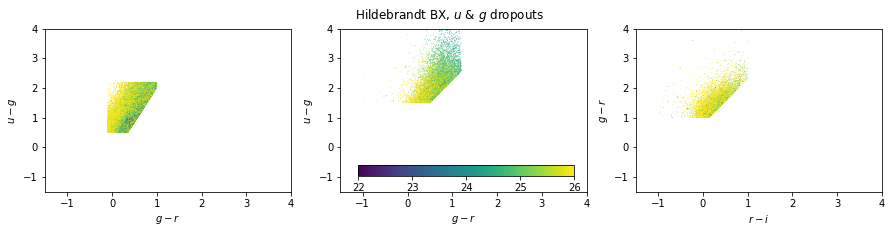

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3)) 

axes[0].scatter(xdrops['g_r_ISO_cor2'], xdrops['u_g_ISO_cor2'], c=xdrops['MAG_ISOCOR_i'], lw=0.0, s=2, vmin=22., vmax=26., marker='.')

axes[0].set_xlabel('$g-r$')
axes[0].set_ylabel('$u-g$')

axes[0].set_xlim(-1.5, 4.)
axes[0].set_ylim(-1.5, 4.)

im        = axes[1].scatter(udrops['g_r_ISO_cor2'], udrops['u_g_ISO_cor2'], c=udrops['MAG_ISOCOR_i'], lw=0.0, s=2, vmin=22., vmax=26., marker='.')

axes[1].set_xlabel('$g-r$')
axes[1].set_ylabel('$u-g$')

axes[1].set_xlim(-1.5, 4.)
axes[1].set_ylim(-1.5, 4.)

axes[2].scatter(gdrops['r_i_ISO_cor2'], gdrops['g_r_ISO_cor2'], c=gdrops['MAG_ISOCOR_i'], lw=0.0, s=2, vmin=22., vmax=26., marker='.')

axes[2].set_xlabel('$r-i$')
axes[2].set_ylabel('$g-r$')

axes[2].set_xlim(-1.5, 4.)
axes[2].set_ylim(-1.5, 4.)           

cax = fig.add_axes([0.415, 0.2, 0.2, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

fig.suptitle('Hildebrandt BX, $u$ & $g$ dropouts')

In [98]:
def splash_drops(dband='u'):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin      = np.ones(len(splash), dtype=bool)

    if dband == 'BX':
        # LATIS, https://arxiv.org/pdf/2002.10676.pdf
        # 0.5 < u − g < 2.2 and −0.1 < g − r < 1.0 and u − g > 0.50 + 2.3(g − r − 0.35).
        isin &= splash['u-g'] >  0.5
        isin &= splash['u-g'] <  2.2
        isin &= splash['g-r'] > -0.1
        isin &= splash['g-r'] <  1.0
        isin &= splash['u-g'] >  0.5 + 2.3 * (splash['g-r'] - 0.35)
    
    elif dband == 'u':
      # u drops.
      # 1.5 < (u − g) and −1.0 < (g − r) < 1.2 and 1.5 · (g − r) < (u − g) − 0.75    
      isin &= splash['u-g'] >  1.5
      isin &= splash['g-r'] > -1.0
      isin &= splash['g-r'] <  1.2
      isin &= 1.5 * splash['g-r'] <  splash['u-g'] - 0.75

    elif dband == 'g':
      # g drops
      # 1.0 < (g − r) and −1.0 < (r − i) < 1.0 and 1.5 · (r − i) < (g − r) − 0.8
      isin &= splash['g-r'] >  1.0
      isin &= splash['r-i'] > -1.0
      isin &= splash['r-i'] <  1.0
      isin &= 1.5 * splash['r-i'] < splash['g-r'] - 0.80
    
    else:
        raise  ValueError('dband of {} is not supported; try [u, g].'.format(dband))
    
    return  isin   

In [99]:
sxdrops = splash_drops(dband='BX')
sudrops = splash_drops(dband='u')
sgdrops = splash_drops(dband='g')

sadrops = sxdrops | sudrops | sgdrops

sxdrops = splash[sxdrops]
sudrops = splash[sudrops]
sgdrops = splash[sgdrops]

sadrops = splash[sadrops]

Text(0.5, 0.98, 'Splash BX, $u$ & $g$ dropouts')

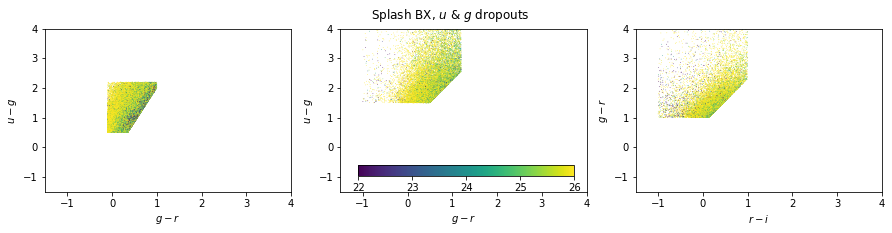

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3)) 

axes[0].scatter(sxdrops['g-r'], sxdrops['u-g'], c=sxdrops['MAG_ISO_hsc_i'], lw=0.0, s=2, vmin=22., vmax=26., marker='.')

axes[0].set_xlabel('$g-r$')
axes[0].set_ylabel('$u-g$')

axes[0].set_xlim(-1.5, 4.)
axes[0].set_ylim(-1.5, 4.)

im        = axes[1].scatter(sudrops['g-r'], sudrops['u-g'], c=sudrops['MAG_ISO_hsc_i'], lw=0.0, s=2, vmin=22., vmax=26., marker='.')

axes[1].set_xlabel('$g-r$')
axes[1].set_ylabel('$u-g$')

axes[1].set_xlim(-1.5, 4.)
axes[1].set_ylim(-1.5, 4.)

axes[2].scatter(sgdrops['r-i'], sgdrops['g-r'], c=sgdrops['MAG_ISO_hsc_i'], lw=0.0, s=2, vmin=22., vmax=26., marker='.')

axes[2].set_xlabel('$r-i$')
axes[2].set_ylabel('$g-r$')

axes[2].set_xlim(-1.5, 4.)
axes[2].set_ylim(-1.5, 4.)           

cax = fig.add_axes([0.415, 0.2, 0.2, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

fig.suptitle('Splash BX, $u$ & $g$ dropouts')

Text(0.5, 0.98, 'Hildebrandt BX, $u$ & $g$ dropouts in CFHTLS Wide')

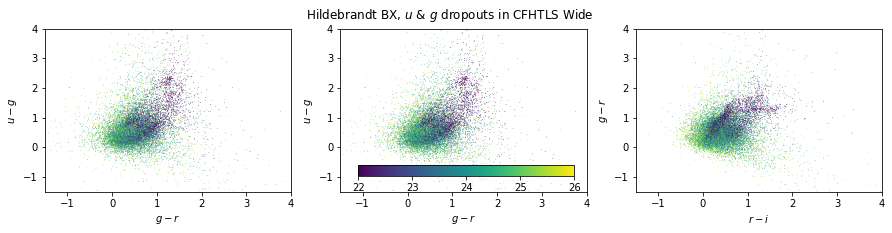

In [104]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3)) 

axes[0].scatter(hilde_wide_sample['g-r'], hilde_wide_sample['u-g'], c=hilde_wide_sample['I_MAG_AUTO'], marker='.', lw=0.0, s=2, vmin=22., vmax=26.)

axes[0].set_xlabel('$g-r$')
axes[0].set_ylabel('$u-g$')

axes[0].set_xlim(-1.5, 4.)
axes[0].set_ylim(-1.5, 4.)

im = axes[1].scatter(hilde_wide_sample['g-r'], hilde_wide_sample['u-g'], c=hilde_wide_sample['I_MAG_AUTO'], marker='.', lw=0.0, s=2, vmin=22., vmax=26.)

axes[1].set_xlabel('$g-r$')
axes[1].set_ylabel('$u-g$')

axes[1].set_xlim(-1.5, 4.)
axes[1].set_ylim(-1.5, 4.)

axes[2].scatter(hilde_wide_sample['r-i'], hilde_wide_sample['g-r'], c=hilde_wide_sample['I_MAG_AUTO'], marker='.', lw=0.0, s=2, vmin=22., vmax=26.)

axes[2].set_xlabel('$r-i$')
axes[2].set_ylabel('$g-r$')

axes[2].set_xlim(-1.5, 4.)
axes[2].set_ylim(-1.5, 4.)

cax = fig.add_axes([0.415, 0.2, 0.2, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

fig.suptitle('Hildebrandt BX, $u$ & $g$ dropouts in CFHTLS Wide')

In [105]:
tiles = io.load_tiles()

In [106]:
isin, indx  = is_point_in_desi(tiles, adrops['ALPHA_J2000'], adrops['DELTA_J2000'], radius=None, return_tile_index=True)

In [107]:
print('Fraction of Hilde in desi: {}'.format(100. * np.count_nonzero(isin) / len(adrops)))

Fraction of Hilde in desi: 100.0


In [108]:
print('Number of unique DESI tiles: {}'.format(len(np.unique(indx))))

Number of unique DESI tiles: 3


In [109]:
tile_radius = desimodel.focalplane.get_tile_radius_deg()

print('Radius of DESI tile: {} [deg.]'.format(tile_radius))

Radius of DESI tile: 1.6280324520485583 [deg.]


In [110]:
# Counts in unique tiles.
uidx, cnts = np.unique(indx, return_counts=True)
uidx, cnts

(array([ 5571,  9566, 14064]), array([45368, 39181, 13858]))

In [152]:
cra  = np.mean(hilde['ALPHA_J2000']) - 1.100
cdec = np.mean(hilde['DELTA_J2000']) - 0.075

Index:  5571, TILEID:  15776,  Counts: 45368
Index:  9566, TILEID:  27299,  Counts: 39181
Index:  14064, TILEID:  40599,  Counts: 13858


Text(0, 0.5, 'DEC')

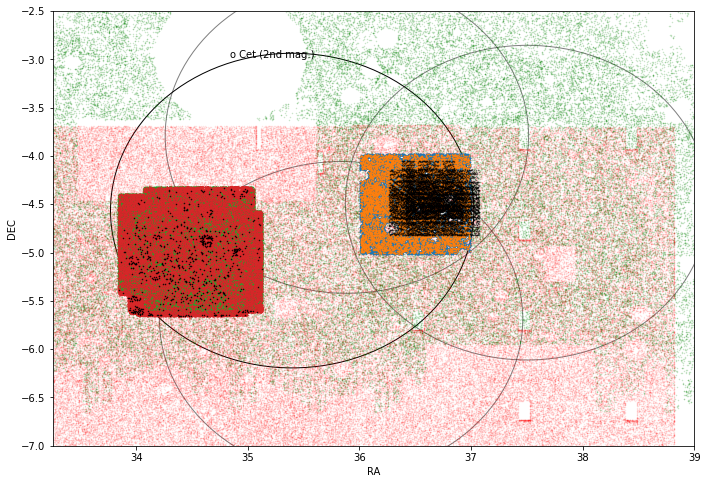

In [153]:
fig, axes  = plt.subplots(1, 1, figsize=(11.5, 8))

pl.figure(fig.number)

for x in uidx:
  print('Index:  {}, TILEID:  {},  Counts: {}'.format(x, tiles[x]['TILEID'], np.count_nonzero(indx == x)))
    
  circles(tiles['RA'][x], tiles['DEC'][x], tile_radius, c='k', fc="None", alpha=0.5)

circles(cra, cdec, tile_radius, c='k', fc="None", alpha=1.0)

pl.plot(grush_D1['ra'],         grush_D1['dec'], marker='.', markersize=1, lw=0.0, c='g', alpha=0.2)
pl.plot(cfhtls_D1['RA'][::20], cfhtls_D1['DEC'][::20], marker='.', markersize=1, lw=0.0, c='r', alpha=0.1)

pl.plot(xdrops['ALPHA_J2000'], xdrops['DELTA_J2000'], marker='.', markersize=1, lw=0.0)
pl.plot(udrops['ALPHA_J2000'], udrops['DELTA_J2000'], marker='.', markersize=1, lw=0.0)

pl.plot(sxdrops['RA'], sxdrops['DEC'], marker='.', markersize=1, lw=0.0)
pl.plot(sudrops['RA'], sudrops['DEC'], marker='.', markersize=1, lw=0.0)

pl.plot(vvds['ALPHA'], vvds['DELTA'], marker='.', markersize=1, lw=0.0, c='k', alpha=0.5)

pl.plot(sxdrops['RA'][sxdrops['ZSPEC'] > 0.], sxdrops['DEC'][sxdrops['ZSPEC'] > 0.], marker='.', markersize=1, lw=0.0, c='k')
pl.plot(sudrops['RA'][sudrops['ZSPEC'] > 0.], sudrops['DEC'][sudrops['ZSPEC'] > 0.], marker='.', markersize=1, lw=0.0, c='k')

plt.text(34.8370, -2.9821, 'o Cet (2nd mag.)')

pl.xlim(33.25, 39.0)
pl.ylim(-7.00, -2.5)

pl.xlabel('RA')
pl.ylabel('DEC')

In [154]:
tiles = Table(tiles)[:1]
tiles

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS,BRIGHTRA [3],BRIGHTDEC [3],BRIGHTVTMAG [3],CENTERID,IMAGEFRAC_G,IMAGEFRAC_R,IMAGEFRAC_Z,IMAGEFRAC_GR,IMAGEFRAC_GRZ,IN_IMAGING
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32,float64,float64,float32,int32,float32,float32,float32,float32,float32,float32
4,334.81451465689173,20.45422737037591,0,1,0.051972657,1.0495182,5185.3125,1.4573705,GRAY,2,335.91403472 .. 334.89587361,20.84826889 .. 21.02411917,6.276 .. 7.687,17290,0.99878496,0.9973043,0.99852544,0.9969012,0.9961801,1.0


In [155]:
tiles['TILEID'] = 9999999
tiles['RA']     = cra
tiles['DEC']    = cdec

In [156]:
tiles

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS,BRIGHTRA [3],BRIGHTDEC [3],BRIGHTVTMAG [3],CENTERID,IMAGEFRAC_G,IMAGEFRAC_R,IMAGEFRAC_Z,IMAGEFRAC_GR,IMAGEFRAC_GRZ,IN_IMAGING
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32,float64,float64,float32,int32,float32,float32,float32,float32,float32,float32
9999999,35.396995278943066,-4.565868891466502,0,1,0.051972657,1.0495182,5185.3125,1.4573705,GRAY,2,335.91403472 .. 334.89587361,20.84826889 .. 21.02411917,6.276 .. 7.687,17290,0.99878496,0.9973043,0.99852544,0.9969012,0.9961801,1.0


Text(0, 0.5, '$N$ / sq. deg.')

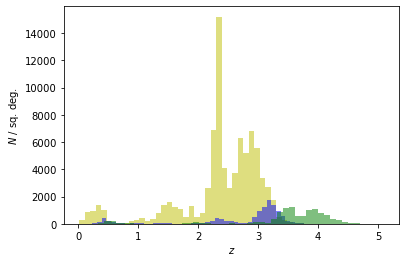

In [171]:
# _ = pl.hist(adrops['Z_PHOT'], bins=50, alpha=0.5, color='r')
_            = pl.hist(xdrops['Z_PHOT'], bins=50, alpha=0.5, color='y')
_            = pl.hist(udrops['Z_PHOT'], bins=50, alpha=0.5, color='b')
_            = pl.hist(gdrops['Z_PHOT'], bins=50, alpha=0.5, color='g')

pl.xlabel('$z$')
pl.ylabel('$N$ / sq. deg.')

In [172]:
bins = _[1]

Text(0, 0.5, '$N$ / sq. deg.')

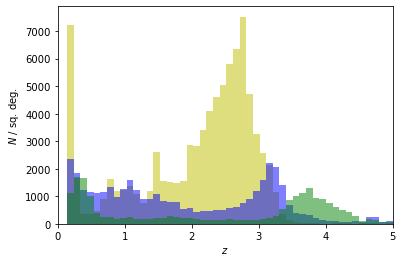

In [173]:
_    = pl.hist(sxdrops['ZPHOT'], bins=bins, alpha=0.5, color='y')
_    = pl.hist(sudrops['ZPHOT'], bins=bins, alpha=0.5, color='b')
_    = pl.hist(sgdrops['ZPHOT'], bins=bins, alpha=0.5, color='g')

pl.xlim(0.0, 5.0)

pl.xlabel('$z$')
pl.ylabel('$N$ / sq. deg.')

Text(0, 0.5, '$N$ / sq. deg.')

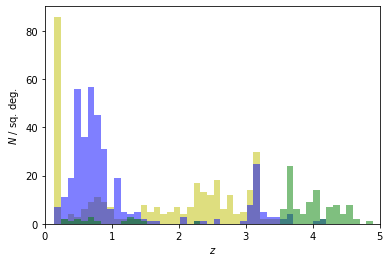

In [174]:
_    = pl.hist(sxdrops['ZSPEC'], bins=bins, alpha=0.5, color='y')
_    = pl.hist(sudrops['ZSPEC'], bins=bins, alpha=0.5, color='b')
_    = pl.hist(sgdrops['ZSPEC'], bins=bins, alpha=0.5, color='g')

pl.xlim(0.0, 5.0)

pl.xlabel('$z$')
pl.ylabel('$N$ / sq. deg.')

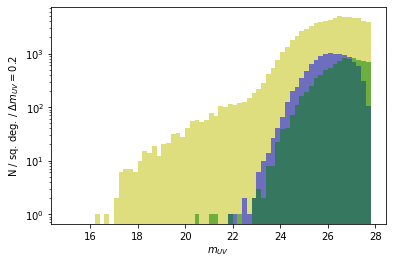

In [176]:
bins = np.arange(15., 28., 0.2)

_    = pl.hist(xdrops['MAG_ISO_r'], bins=bins, alpha=0.5, color='y')
_    = pl.hist(udrops['MAG_ISO_r'], bins=bins, alpha=0.5, color='b')
_    = pl.hist(gdrops['MAG_ISO_i'], bins=bins, alpha=0.5, color='g')

pl.xlabel('$m_{UV}$')
pl.ylabel('N / sq. deg. / $\Delta m_{UV} = 0.2$')

pl.yscale('log')

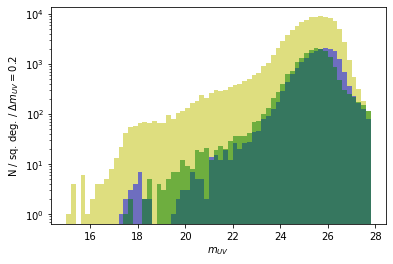

In [178]:
bins = np.arange(15., 28., 0.2)

_    = pl.hist(sxdrops['MAG_AUTO_hsc_r'], bins=bins, alpha=0.5, color='y')
_    = pl.hist(sudrops['MAG_AUTO_hsc_r'], bins=bins, alpha=0.5, color='b')
_    = pl.hist(sgdrops['MAG_AUTO_hsc_i'], bins=bins, alpha=0.5, color='g')

pl.xlabel('$m_{UV}$')
pl.ylabel('N / sq. deg. / $\Delta m_{UV} = 0.2$')

pl.yscale('log')

In [180]:
# Goldrush g-dropouts. 
grush_desilbg              = grush_D1[is_point_in_desi(tiles, grush_D1['ra'], grush_D1['dec'], radius=None, return_tile_index=False)]

In [183]:
# Goldrush g-dropouts. 
splash_desilbg             = splash[is_point_in_desi(tiles, splash['RA'], splash['DEC'], radius=None, return_tile_index=False)]

In [181]:
c                          = SkyCoord(ra=tiles['RA'] * u.degree, dec= tiles['DEC']* u.degree)
catalog                    = SkyCoord(ra=cfhtls_D1['RA'] * u.degree, dec=cfhtls_D1['DEC'] * u.degree)

idxc, idxcatalog, d2d, d3d = catalog.search_around_sky(c, tile_radius * u.deg)

d2d                        = [x.deg * 60. * 60. for x in d2d]

In [182]:
cfhtls_desilbg             = cfhtls_D1[idxcatalog]

Text(0, 0.5, 'DEC')

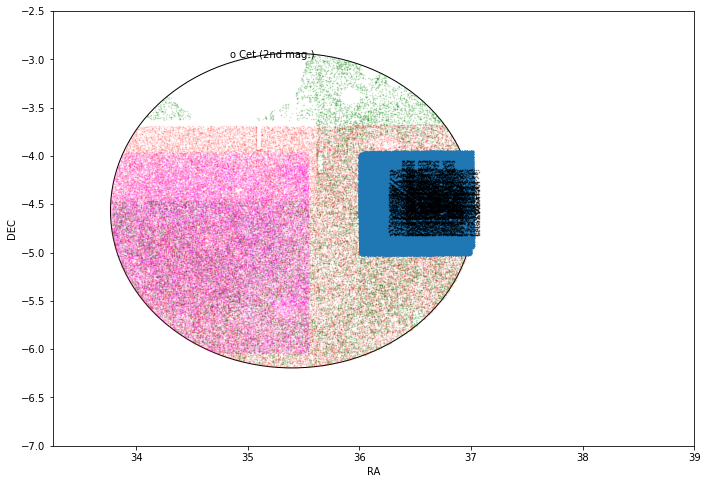

In [187]:
fig, axes                  = plt.subplots(1, 1, figsize=(11.5, 8))

pl.figure(fig.number)

circles(cra, cdec, tile_radius, c='k', fc="None", alpha=1.0)

pl.plot(grush_desilbg['ra'],   grush_desilbg['dec'], marker='.', markersize=1, lw=0.0, c='g', alpha=0.2)
pl.plot(cfhtls_desilbg['RA'][::20], cfhtls_desilbg['DEC'][::20], marker='.', markersize=1, lw=0.0, c='r', alpha=0.1)

pl.plot(splash_desilbg['RA'][::20], splash_desilbg['DEC'][::20], marker='.', markersize=1, lw=0.0, c='magenta', alpha=0.1)

pl.plot(hilde['ALPHA_J2000'], hilde['DELTA_J2000'], marker='.', markersize=1, lw=0.0)

pl.plot(vvds['ALPHA'], vvds['DELTA'], marker='.', markersize=1, lw=0.0, c='k', alpha=0.5)

plt.text(34.8370, -2.9821, 'o Cet (2nd mag.)')

pl.xlim(33.25, 39.0)
pl.ylim(-7.00, -2.5)

pl.xlabel('RA')
pl.ylabel('DEC')

In [190]:
cfhtls_desilbg['u-g'] = cfhtls_desilbg['U_MAG_AUTO'] - cfhtls_desilbg['G_MAG_AUTO']
cfhtls_desilbg['g-r'] = cfhtls_desilbg['G_MAG_AUTO'] - cfhtls_desilbg['R_MAG_AUTO']
cfhtls_desilbg['r-i'] = cfhtls_desilbg['R_MAG_AUTO'] - cfhtls_desilbg['I_MAG_AUTO']

In [188]:
def wide_drops(dband='u'):
    isin = np.ones(len(cfhtls_desilbg), dtype=bool)
    
    # https://arxiv.org/pdf/0903.3951.pdf    
    if dband == 'BX':
        # LATIS, https://arxiv.org/pdf/2002.10676.pdf
        # 0.5 < u − g < 2.2 and −0.1 < g − r < 1.0 and u − g > 0.50 + 2.3(g − r − 0.35).
        isin &= cfhtls_desilbg['u-g'] >  0.5
        isin &= cfhtls_desilbg['u-g'] <  2.2
        isin &= cfhtls_desilbg['g-r'] > -0.1
        isin &= cfhtls_desilbg['g-r'] <  1.0
        isin &= cfhtls_desilbg['u-g'] >  0.5 + 2.3 * (cfhtls_desilbg['g-r'] - 0.35)
    
    elif dband == 'u':
      # u drops.
      # 1.5 < (u − g) and −1.0 < (g − r) < 1.2 and 1.5 · (g − r) < (u − g) − 0.75    
      isin &= cfhtls_desilbg['u-g'] >  0.75
      isin &= cfhtls_desilbg['g-r'] > -1.0
      isin &= cfhtls_desilbg['g-r'] <  1.2
      isin &= 1.5 * cfhtls_desilbg['g-r'] <  cfhtls_desilbg['u-g'] - 0.75

    elif dband == 'g':
      # g drops
      # 1.0 < (g − r) and −1.0 < (r − i) < 1.0 and 1.5 · (r − i) < (g − r) − 0.8
      isin &= cfhtls_desilbg['g-r'] >  1.0
      isin &= cfhtls_desilbg['r-i'] > -1.0
      isin &= cfhtls_desilbg['r-i'] <  1.0
      isin &= 1.5 * cfhtls_desilbg['r-i'] < cfhtls_desilbg['g-r'] - 0.80
    
    else:
        raise  ValueError('dband of {} is not supported; try [u, g].'.format(dband))
    
    return  isin    

In [191]:
wxdrops                    = wide_drops(dband='BX')
wudrops                    = wide_drops(dband='u')

In [285]:
sample                     = Table()

# CFHTLS Deep Field u-dropouts.
toadd                      = Table()

toadd['RA']                = udrops['ALPHA_J2000']
toadd['DEC']               = udrops['DELTA_J2000']

toadd['PRIORITY']          = 9999

toadd['SAMPLE']            = 'U-CFHTLS-DEEP'
toadd['DET_MAG']           = udrops['MAG_ISO_i']

toadd                      = toadd[udrops['MAG_ISO_i'] <= 24.0]

print('Selecting {}% of deep field u-dropouts.'.format(100. * np.count_nonzero(udrops['MAG_ISO_i'] <= 24.0) / len(udrops)))

sample                     = vstack((sample, toadd))

Selecting 2.254711995772415% of deep field u-dropouts.


In [286]:
# CFHTLS Deep BX-dropouts. 
toadd                      = Table()

toadd['RA']                = xdrops['ALPHA_J2000']
toadd['DEC']               = xdrops['DELTA_J2000']

toadd['PRIORITY']          = 9998

toadd['SAMPLE']            = 'BX-CFHTLS-DEEP'
toadd['DET_MAG']           = xdrops['MAG_ISO_r']

toadd                      = toadd[xdrops['MAG_ISO_r'] <= 24.0]

print('Selecting {}% of deep field bx-dropouts.'.format(100. * np.count_nonzero(xdrops['MAG_ISO_r'] <= 24.0) / len(xdrops)))

sample                     = vstack((sample, toadd))

Selecting 4.601646702993351% of deep field bx-dropouts.


In [287]:
# SPLASH u-dropouts.
toadd                      = Table()

toadd['RA']                = sudrops['RA']
toadd['DEC']               = sudrops['DEC']

toadd['PRIORITY']                         =  9997
toadd['PRIORITY'][sudrops['ZSPEC'] > 0.0] = 10002

toadd['SAMPLE']                           = 'U-SPLH'
toadd['SAMPLE'][sudrops['ZSPEC'] > 0.0]   = 'U-SPLH-SP'

toadd['DET_MAG']           = sudrops['MAG_AUTO_hsc_i']

toadd                      = toadd[sudrops['MAG_AUTO_hsc_i'] <= 24.0]

print('Selecting {}% of SPLASH field u-dropouts.'.format(100. * np.count_nonzero(sudrops['MAG_AUTO_hsc_i'] <= 24.0) / len(sudrops)))

sample                     = vstack((sample, toadd))

Selecting 49.424426129010286% of SPLASH field u-dropouts.


<ipython-input-287-54587bb8af1d>:11: StringTruncateWarning: truncated right side string(s) longer than 6 character(s) during assignment
  toadd['SAMPLE'][sudrops['ZSPEC'] > 0.0]   = 'U-SPLH-SP'


In [288]:
# SPLASH BX-dropouts.
toadd                      = Table()

toadd['RA']                = sxdrops['RA']
toadd['DEC']               = sxdrops['DEC']

toadd['PRIORITY']                         = 9996
toadd['PRIORITY'][sxdrops['ZSPEC'] > 0.0] = 10001

toadd['SAMPLE']                           = 'BX-SPLH'
toadd['SAMPLE'][sxdrops['ZSPEC'] > 0.0]   = 'BX-SPLH-SP'

toadd['DET_MAG']           = sxdrops['MAG_AUTO_hsc_r']

toadd                      = toadd[sxdrops['MAG_AUTO_hsc_r'] <= 24.0]

print('Selecting {}% of SPLASH field x-dropouts.'.format(100. * np.count_nonzero(sxdrops['MAG_AUTO_hsc_r'] <= 24.0) / len(sxdrops)))

sample                     = vstack((sample, toadd))

Selecting 11.643795790208165% of SPLASH field x-dropouts.


<ipython-input-288-f13bf656f59c>:11: StringTruncateWarning: truncated right side string(s) longer than 7 character(s) during assignment
  toadd['SAMPLE'][sxdrops['ZSPEC'] > 0.0]   = 'BX-SPLH-SP'


In [289]:
# Goldrush g-dropouts
toadd                      = Table()

toadd['RA']                = grush_desilbg['ra']
toadd['DEC']               = grush_desilbg['dec']

toadd['PRIORITY']          = 9995

toadd['SAMPLE']            = 'G-GOLDRUSH'
toadd['DET_MAG']           = grush_desilbg['icmodel_mag']

toadd                      = toadd[grush_desilbg['icmodel_mag'] < 25.5]

# Downsample by a factor of 5. 
toadd                      = toadd[::5]

print('Selecting {}% of goldrush g-dropouts.'.format(100. * np.count_nonzero(grush_desilbg['icmodel_mag'] < 25.5) / len(grush_desilbg)))

sample                     = vstack((sample, toadd))

Selecting 91.08144941478275% of goldrush g-dropouts.


In [290]:
# CFHTLS Wide bx-dropouts. 
toadd                      = Table()

toadd['RA']                = cfhtls_desilbg[wxdrops]['RA'].data * u.deg
toadd['DEC']               = cfhtls_desilbg[wxdrops]['DEC'].data * u.deg

toadd['PRIORITY']          = 9994

toadd['SAMPLE']            = 'BX-CFHTLS-WIDE'
toadd['DET_MAG']           = cfhtls_desilbg[wxdrops]['R_MAG_AUTO'].data * u.mag

toadd                      = toadd[cfhtls_desilbg[wxdrops]['R_MAG_AUTO'] < 24.0]

print('Selecting {}% of wide field bx-dropouts.'.format(100. * np.count_nonzero(cfhtls_desilbg[wxdrops]['R_MAG_AUTO'] < 24.0) / len(cfhtls_desilbg[wxdrops])))

sample                     = vstack((sample, toadd))

Selecting 23.448308470649426% of wide field bx-dropouts.


In [291]:
# CFHTLS Wide u-dropouts.
toadd                      = Table()

toadd['RA']                = cfhtls_desilbg[wudrops]['RA'].data * u.deg
toadd['DEC']               = cfhtls_desilbg[wudrops]['DEC'].data * u.deg

toadd['PRIORITY']          = 9993

toadd['SAMPLE']            = 'U-CFHTLS-WIDE'
toadd['DET_MAG']           = cfhtls_desilbg[wudrops]['I_MAG_AUTO'].data * u.mag

toadd                      = toadd[cfhtls_desilbg[wudrops]['I_MAG_AUTO'] < 24.0]

print('Selecting {}% of wide field u-dropouts.'.format(100. * np.count_nonzero(cfhtls_desilbg[wudrops]['I_MAG_AUTO'] < 24.0) / len(cfhtls_desilbg[wudrops])))

sample                     = vstack((sample, toadd))

Selecting 15.58273621063156% of wide field u-dropouts.


In [292]:
sample

RA,DEC,PRIORITY,SAMPLE,DET_MAG
deg,deg,,,mag
float64,float64,int64,str14,float64
36.4760378,-5.0062358,9999,U-CFHTLS-DEEP,23.7020
36.6279474,-5.0049873,9999,U-CFHTLS-DEEP,23.9564
36.5556870,-5.0038913,9999,U-CFHTLS-DEEP,19.2306
36.6093080,-4.9808886,9999,U-CFHTLS-DEEP,23.7728
36.5999736,-4.9773864,9999,U-CFHTLS-DEEP,23.8886
36.6199755,-4.9777879,9999,U-CFHTLS-DEEP,23.4642
36.5584638,-4.9765714,9999,U-CFHTLS-DEEP,23.8161
36.1620815,-4.9752556,9999,U-CFHTLS-DEEP,23.8331


In [293]:
sample['TILEID']           = tiles['TILEID']

sample['TARGETID']         = np.array(range(len(sample)))

sample['DESI_TARGET']      = desi_mask.ELG
sample['BGS_TARGET']       = np.zeros(len(sample), dtype='i8')
sample['MWS_TARGET']       = np.zeros(len(sample), dtype='i8')

# ELG -like
sample['SUBPRIORITY']      = np.random.uniform(0, 1, len(sample))
sample['BRICKNAME']        = np.full(len(sample), '000p0000')    #- required !?!
sample['BRICKID']          = np.full(len(sample), 0)    #- required !?!
sample['BRICK_OBJID']      = np.arange(len(sample))

sample['OBSCONDITIONS']    = np.ones(len(sample), dtype='i4') * obsconditions.DARK
sample['NUMOBS_MORE']      = np.ones(len(sample), dtype='i8')

#- dummy values for fluxes
for filt in ['G', 'R', 'Z']:
    sample['FIBERFLUX_'+filt]      = np.zeros(len(sample), dtype='f4')
    sample['FIBERFLUX_IVAR_'+filt] = np.ones(len(sample), dtype='f4')
        
sample.meta['EXTNAME']     = 'MTL'

In [294]:
sample

RA,DEC,PRIORITY,SAMPLE,DET_MAG,TILEID,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,BRICKNAME,BRICKID,BRICK_OBJID,OBSCONDITIONS,NUMOBS_MORE,FIBERFLUX_G,FIBERFLUX_IVAR_G,FIBERFLUX_R,FIBERFLUX_IVAR_R,FIBERFLUX_Z,FIBERFLUX_IVAR_Z
deg,deg,,,mag,,,,,,,,,,,,,,,,,
float64,float64,int64,str14,float64,int32,int64,int64,int64,int64,float64,str8,int64,int64,int32,int64,float32,float32,float32,float32,float32,float32
36.4760378,-5.0062358,9999,U-CFHTLS-DEEP,23.7020,9999999,0,2,0,0,0.10349848373595383,000p0000,0,0,1,1,0.0,1.0,0.0,1.0,0.0,1.0
36.6279474,-5.0049873,9999,U-CFHTLS-DEEP,23.9564,9999999,1,2,0,0,0.8107424977416868,000p0000,0,1,1,1,0.0,1.0,0.0,1.0,0.0,1.0
36.5556870,-5.0038913,9999,U-CFHTLS-DEEP,19.2306,9999999,2,2,0,0,0.44486026338323836,000p0000,0,2,1,1,0.0,1.0,0.0,1.0,0.0,1.0
36.6093080,-4.9808886,9999,U-CFHTLS-DEEP,23.7728,9999999,3,2,0,0,0.882449780470479,000p0000,0,3,1,1,0.0,1.0,0.0,1.0,0.0,1.0
36.5999736,-4.9773864,9999,U-CFHTLS-DEEP,23.8886,9999999,4,2,0,0,0.6021606308058159,000p0000,0,4,1,1,0.0,1.0,0.0,1.0,0.0,1.0
36.6199755,-4.9777879,9999,U-CFHTLS-DEEP,23.4642,9999999,5,2,0,0,0.8026210307248798,000p0000,0,5,1,1,0.0,1.0,0.0,1.0,0.0,1.0
36.5584638,-4.9765714,9999,U-CFHTLS-DEEP,23.8161,9999999,6,2,0,0,0.1068364289687388,000p0000,0,6,1,1,0.0,1.0,0.0,1.0,0.0,1.0
36.1620815,-4.9752556,9999,U-CFHTLS-DEEP,23.8331,9999999,7,2,0,0,0.13063964083301116,000p0000,0,7,1,1,0.0,1.0,0.0,1.0,0.0,1.0


In [295]:
targetlist                = Table()

targetlist['RA']          = np.array(sample['RA'],   dtype='>f8')
targetlist['DEC']         = np.array(sample['DEC'],  dtype='>f8')

targetlist['PRIORITY']    = sample['PRIORITY']
targetlist['SUBPRIORITY'] = sample['SUBPRIORITY']
targetlist['TILEID']      = sample['TILEID']
targetlist['SAMPLE']      = sample['SAMPLE']

targetlist['PMRA']        = np.zeros(len(sample),   dtype='>f4')
targetlist['PMDEC']       = np.zeros(len(sample),   dtype='>f4')

targetlist['REF_EPOCH']   = np.zeros(len(sample),   dtype='>f4')
targetlist['OVERRIDE']    = np.zeros(len(sample),   dtype='>f4')

targetlist.sort('PRIORITY')

# Highest priority first.
targetlist                = targetlist[::-1]

In [296]:
targetlist['VVDS']         = np.zeros(len(targetlist))

# Prioritise VVDS of those in sample. 
c                          = SkyCoord(ra=vvds['ALPHA'] * u.degree, dec= vvds['DELTA']* u.degree)
catalog                    = SkyCoord(ra=targetlist['RA'] * u.degree, dec=targetlist['DEC'] * u.degree)

idxc, idxcatalog, d2d, d3d = catalog.search_around_sky(c, (0.4 / 60. / 60.) * u.deg)

d2d                        = [x.deg * 60. * 60. for x in d2d]

targetlist['PRIORITY'][idxcatalog] = 10000
targetlist['VVDS'][idxcatalog] = 1

targetlist.sort('PRIORITY')

# Highest priority first.
targetlist                 = targetlist[::-1] 

In [297]:
len(idxcatalog)

1098

In [298]:
targetlist

RA,DEC,PRIORITY,SUBPRIORITY,TILEID,SAMPLE,PMRA,PMDEC,REF_EPOCH,OVERRIDE,VVDS
float64,float64,int64,float64,int32,str14,float32,float32,float32,float32,float64
34.71778869218519,-5.650372821997257,10002,0.9365996345915348,9999999,U-SPLH,0.0,0.0,0.0,0.0,0.0
34.63403615684852,-4.898426342489782,10002,0.927582044181457,9999999,U-SPLH,0.0,0.0,0.0,0.0,0.0
34.596672809626746,-4.897402533863675,10002,0.6500208409580918,9999999,U-SPLH,0.0,0.0,0.0,0.0,0.0
34.29688944939513,-4.355411377479095,10002,0.24879024493475033,9999999,U-SPLH,0.0,0.0,0.0,0.0,0.0
34.67153914561114,-4.897066417061621,10002,0.5233475490407903,9999999,U-SPLH,0.0,0.0,0.0,0.0,0.0
33.932947302391206,-5.121181895459841,10002,0.40809188012206665,9999999,U-SPLH,0.0,0.0,0.0,0.0,0.0
34.60847608882784,-4.821914746330818,10002,0.5259379170214422,9999999,U-SPLH,0.0,0.0,0.0,0.0,0.0
34.970166659285795,-5.599635366137441,10002,0.9813138858982037,9999999,U-SPLH,0.0,0.0,0.0,0.0,0.0
34.602453713410206,-4.358387646310514,10002,0.6161169895955871,9999999,U-SPLH,0.0,0.0,0.0,0.0,0.0


In [299]:
upriorities = np.unique(targetlist['PRIORITY'])[::-1]

In [300]:
upriorities

10002
10001
10000
9999
9998
9997
9996
9995
9994
9993


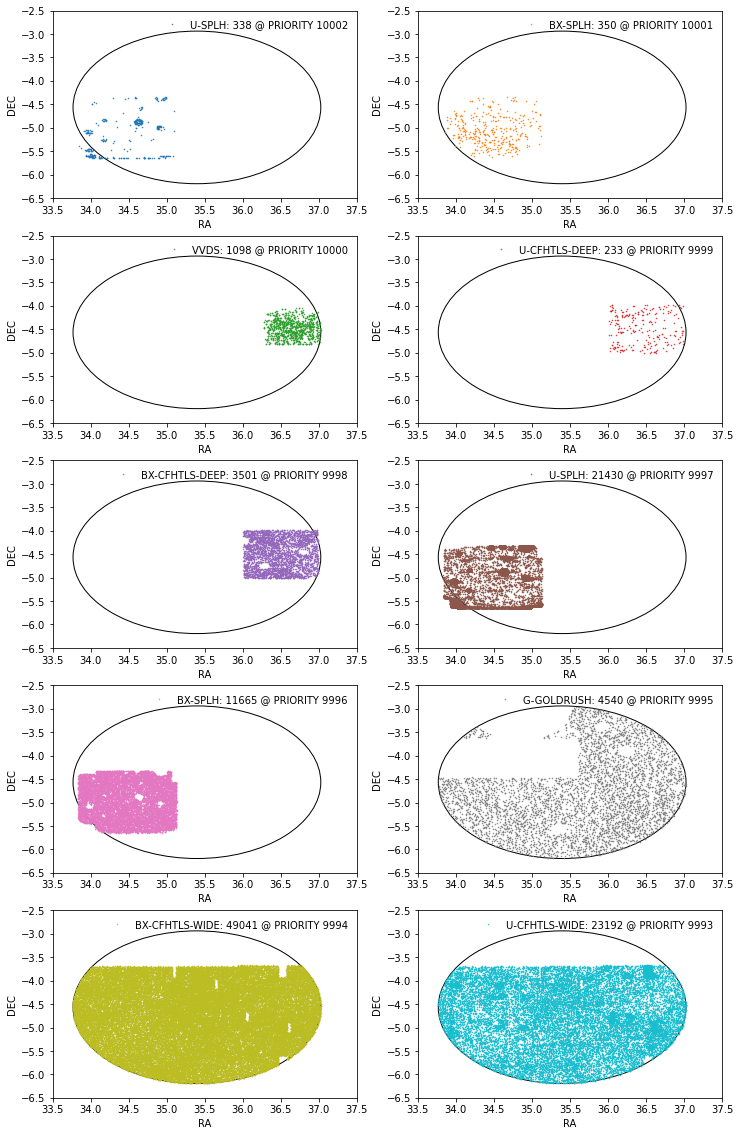

In [301]:
fig, axes = plt.subplots(5, 2, figsize=(12, 20))

colors    = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, up in enumerate(upriorities):
  pl.figure(fig.number)  

  plt.sca(axes[np.int(i/2), i%2]) 

  circles(cra, cdec, tile_radius, c='k', fc="None", alpha=1.0)

  isin = targetlist['PRIORITY'] == up 
  
  label = targetlist[isin]['SAMPLE'][0] + ': {} @ PRIORITY {}'.format(np.count_nonzero(isin), up)  
     
  if up == 10000:
    label = 'VVDS: {} @ PRIORITY {}'.format(np.count_nonzero(isin), up) 
    
  pl.plot(targetlist[isin]['RA'], targetlist[isin]['DEC'], marker='.', markersize=1, lw=0.0, label=label, c=colors[i])
        
  pl.xlim(33.5, 37.5)
  pl.ylim(-6.5, -2.5)

  pl.xlabel('RA')
  pl.ylabel('DEC')
    
  pl.legend(frameon=False)

pl.savefig('DESILBG.pdf')

In [302]:
targetlist.write('/global/homes/m/mjwilson/DESILBG/target/proposals/indata/LBGLAE.fits', overwrite=True)

In [255]:
skies = fitsio.read('/global/cfs/cdirs/desi/target/catalogs/dr8/0.32.0/skies/skies-dr8-0.32.0.fits')

In [256]:
stds  = fitsio.read('/global/cfs/cdirs/desi/target/catalogs/dr8/0.32.0/gfas/gfas-dr8-0.32.0.fits')

In [258]:
tiles

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS,BRIGHTRA [3],BRIGHTDEC [3],BRIGHTVTMAG [3],CENTERID,IMAGEFRAC_G,IMAGEFRAC_R,IMAGEFRAC_Z,IMAGEFRAC_GR,IMAGEFRAC_GRZ,IN_IMAGING
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32,float64,float64,float32,int32,float32,float32,float32,float32,float32,float32
9999999,36.99699527894307,-4.490868891466502,0,1,0.051972657,1.0495182,5185.3125,1.4573705,GRAY,2,335.91403472 .. 334.89587361,20.84826889 .. 21.02411917,6.276 .. 7.687,17290,0.99878496,0.9973043,0.99852544,0.9969012,0.9961801,1.0


In [260]:
for i in range(len(tiles)):
    Table(tiles[i]).write('/global/homes/m/mjwilson/DESILBG/target/proposals/tiles/tiles_{}.fits'.format(tiles['TILEID'][i]), overwrite=True)

In [ ]:
nskies                 = skies[is_point_in_desi(tiles, skies['RA'], skies['DEC'], radius=None, return_tile_index=False)]

In [99]:
Table(nskies).write('/global/homes/m/mjwilson/target/proposals/tiles/skies_9999999.fits', format='fits', overwrite=True)

In [100]:
nstds                  = stds[is_point_in_desi(tiles, stds['RA'], stds['DEC'], radius=None, return_tile_index=False)]

In [101]:
nstds                  = Table(nstds)
nstds['SUBPRIORITY']   = np.random.uniform(0, 1, len(nstds))
nstds['OBSCONDITIONS'] = np.ones(len(nstds), dtype='i4') * obsconditions.DARK
nstds['DESI_TARGET']   = desi_mask.STD_FAINT

In [102]:
nstds                  = nstds[nstds['TARGETID'] > 0]

In [104]:
nstds.write('/global/homes/m/mjwilson/target/proposals/tiles/stds_11155.fits', format='fits', overwrite=True)

In [105]:
rundatestr = "2020-01-01T00:00:00"
rundate    = datetime.strptime(rundatestr, "%Y-%m-%dT%H:%M:%S")

rundate

datetime.datetime(2020, 1, 1, 0, 0)

In [112]:
cmd  = 'fiberassign --overwrite --mtl /global/homes/m/mjwilson/DESILBG/target/proposals/indata/CFHTLSD2_mtl.fits' 
cmd += ' --stdstar /global/homes/m/mjwilson/DESILBG/target/proposals/tiles/stds_11155.fits' 
cmd += ' --sky /global/homes/m/mjwilson/DESILBG/target/proposals/tiles/skies_11155.fits'
cmd += ' --rundate {}'.format(rundatestr)
cmd += ' --footprint /global/homes/m/mjwilson/DESILBG/target/proposals/tiles/tiles_11155.fits'
cmd += ' --outdir /global/homes/m/mjwilson/DESILBG/target/proposals/fiberassign/'

In [113]:
print(cmd)

fiberassign --overwrite --mtl /global/homes/m/mjwilson/DESILBG/target/proposals/indata/CFHTLSD2_mtl.fits --stdstar /global/homes/m/mjwilson/DESILBG/target/proposals/tiles/stds_11155.fits --sky /global/homes/m/mjwilson/DESILBG/target/proposals/tiles/skies_11155.fits --rundate 2020-01-01T00:00:00 --footprint /global/homes/m/mjwilson/DESILBG/target/proposals/tiles/tiles_11155.fits --outdir /global/homes/m/mjwilson/DESILBG/target/proposals/fiberassign/


In [114]:
os.system(cmd)

0

In [116]:
fiberassign = Table.read('/global/homes/m/mjwilson/DESILBG/target/proposals/fiberassign/fiberassign-011155.fits')

In [117]:
fiberassign

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,FIELD_POS,SeqNr,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_ISOCOR,FLUXERR_ISOCOR,MAG_ISOCOR,MAGERR_ISOCOR,FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,FLUX_BEST,FLUXERR_BEST,MAG_BEST,MAGERR_BEST,KRON_RADIUS,BackGr,Level,MU_THRESHOLD,MaxVal,MU_MAX,NPIX,ISOAREA_WORLD,XMIN_IMAGE,YMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,Xpos,Ypos,X_WORLD,Y_WORLD,ALPHA_SKY,DELTA_SKY,ALPHA_J2000,DELTA_J2000,ALPHA_B1950,DELTA_B1950,XM2,YM2,Corr,X2_WORLD,Y2_WORLD,XY_WORLD,CXX_IMAGE,CYY_IMAGE,CXY_IMAGE,CXX_WORLD,CYY_WORLD,CXY_WORLD,A,B,A_WORLD,B_WORLD,Theta,THETA_WORLD,THETA_SKY,THETA_J2000,THETA_B1950,ELONGATION,ELLIPTICITY,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,ERRX2_WORLD,ERRY2_WORLD,ERRXY_WORLD,ERRCXX_IMAGE,ERRCYY_IMAGE,ERRCXY_IMAGE,ERRCXX_WORLD,ERRCYY_WORLD,ERRCXY_WORLD,ERRA_IMAGE,ERRB_IMAGE,ERRA_WORLD,ERRB_WORLD,ERRTHETA_IMAGE,ERRTHETA_WORLD,ERRTHETA_SKY,ERRTHETA_J2000,ERRTHETA_B1950,FWHM_IMAGE,FWHM_WORLD,ISO0,ISO1,ISO2,ISO3,ISO4,ISO5,ISO6,ISO7,Flag,FLUX_RADIUS,IMAFLAGS_ISO,NIMAFLAGS_ISO,CLASS_STAR,MAG_ISO_u,MAG_ISOCOR_u,MAG_AUTO_u,MAGERR_ISO_u,MAGERR_ISOCOR_u,MAGERR_AUTO_u,MAG_LIM_u,FLUX_ISO_u,FLUX_ISOCOR_u,FLUX_AUTO_u,FLUXERR_ISO_u,FLUXERR_ISOCOR_u,FLUXERR_AUTO_u,MAG_ISO_g,MAG_ISOCOR_g,MAG_AUTO_g,MAGERR_ISO_g,MAGERR_ISOCOR_g,MAGERR_AUTO_g,MAG_LIM_g,FLUX_ISO_g,FLUX_ISOCOR_g,FLUX_AUTO_g,FLUXERR_ISO_g,FLUXERR_ISOCOR_g,FLUXERR_AUTO_g,MAG_ISO_r,MAG_ISOCOR_r,MAG_AUTO_r,MAGERR_ISO_r,MAGERR_ISOCOR_r,MAGERR_AUTO_r,MAG_LIM_r,FLUX_ISO_r,FLUX_ISOCOR_r,FLUX_AUTO_r,FLUXERR_ISO_r,FLUXERR_ISOCOR_r,FLUXERR_AUTO_r,MAG_ISO_i,MAG_ISOCOR_i,MAG_AUTO_i,MAGERR_ISO_i,MAGERR_ISOCOR_i,MAGERR_AUTO_i,MAG_LIM_i,FLUX_ISO_i,FLUX_ISOCOR_i,FLUX_AUTO_i,FLUXERR_ISO_i,FLUXERR_ISOCOR_i,FLUXERR_AUTO_i,MAG_ISO_z,MAG_ISOCOR_z,MAG_AUTO_z,MAGERR_ISO_z,MAGERR_ISOCOR_z,MAGERR_AUTO_z,MAG_LIM_z,FLUX_ISO_z,FLUX_ISOCOR_z,FLUX_AUTO_z,FLUXERR_ISO_z,FLUXERR_ISOCOR_z,FLUXERR_AUTO_z,MASK_u,MASK_g,MASK_r,MASK_i,MASK_z,MASK_STARS,u_g_ISO,g_r_ISO,r_i_ISO,i_z_ISO,u_r_ISO,g_i_ISO,r_z_ISO,u_i_ISO,g_z_ISO,u_z_ISO,Z_PHOT,CHI_SQUARE,PROB_CHI,SpT,Nage,Age,Av,b,Zinf99,Zsup99,Zinf90,Zsup90,Zinf68,Zsup68,Zwm,PROB_CHIwm,MAGABS_i,P_int,Ly_forest,Z_PHOT2,PROB_CHI2,b_scale,maskgsct,maskgscw,maskgscw2,maskast1,maskast2,maskast3,maskast4,masksa,Z_PHOT_BC,CHI_SQUARE_BC,PROB_CHI_BC,SpT_BC,Nage_BC,Age_BC,Av_BC,b_BC,Zinf99_BC,Zsup99_BC,Zinf90_BC,Zsup90_BC,Zinf68_BC,Zsup68_BC,Zwm_BC,PROB_CHIwm_BC,MAGABS_i_BC,Ly_forest_BC,Z_PHOT2_BC,PROB_CHI2_BC,EXT_u,EXT_g,EXT_r,EXT_i,EXT_z,u_g_ISO_cor,u_r_ISO_cor,u_i_ISO_cor,u_z_ISO_cor,g_r_ISO_cor,g_i_ISO_cor,g_z_ISO_cor,r_i_ISO_cor,r_z_ISO_cor,i_z_ISO_cor,Z_B_V3,Z_B_MIN_V3,Z_B_MAX_V3,T_B_V3,ODDS_V3,Z_ML_V3,T_ML_V3,CHI_SQUARED_BPZ_V3,M_0_V3,u_g_ISO_cor2,u_r_ISO_cor2,u_i_ISO_cor2,u_z_ISO_cor2,g_r_ISO_cor2,g_i_ISO_cor2,g_z_ISO_cor2,r_i_ISO_cor2,r_z_ISO_cor2,i_z_ISO_cor2,TILEID,DESI_TARGET,BGS_TARGET,MWS_TARGET,BRICKNAME,BRICKID,BRICK_OBJID,NUMOBS_MORE,FIBERFLUX_G,FIBERFLUX_IVAR_G,FIBERFLUX_R,FIBERFLUX_IVAR_R,FIBERFLUX_Z,FIBERFLUX_IVAR_Z,RELEASE,BLOBDIST,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,TARGET_RA_IVAR,TARGET_DEC_IVAR,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,REF_ID,REF_CAT,PARALLAX,PARALLAX_IVAR,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,URAT_ID,URAT_SEP
int64,int16,int32,int32,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int16,int32,float64,int32,int16,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,int32,int32,int32,int32,float32,float32,float64,float64,float64,float64,float64,float64,f

In [118]:
np.unique(fiberassign['PRIORITY'], return_counts=True)

(<Column name='PRIORITY' dtype='int32' length=2>
    0
 9999, array([4430,  570]))

In [122]:
science = fiberassign[fiberassign['PRIORITY'] == 9999]

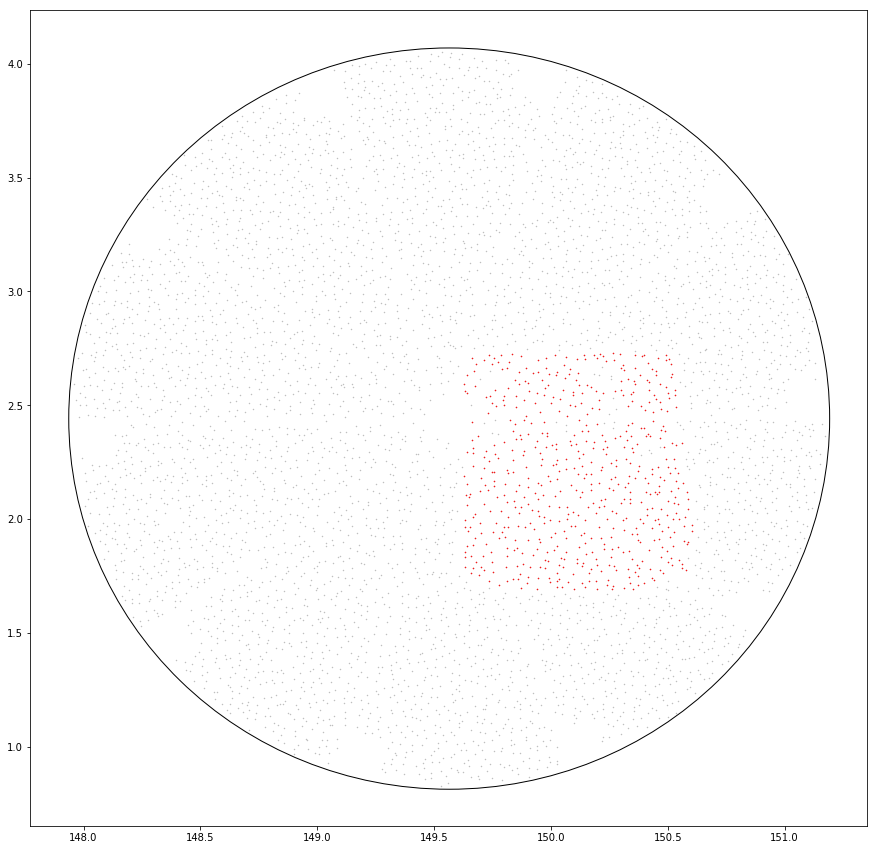

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

plt.sca(ax)

circles(tiles['RA'][3754], tiles['DEC'][3754], tile_radius, c='k', fc='w')

ax.plot(fiberassign['TARGET_RA'], fiberassign['TARGET_DEC'], marker='.', lw=0.0, markersize=1, c='k', alpha=0.25)
ax.plot(science['TARGET_RA'],         science['TARGET_DEC'], marker='.', lw=0.0, markersize=1, c='r')

In [139]:
len(science)

570

Done.